# Requirements

In [1]:
import pandas as pd 
import wandb

def load_metrics_from_wandb(proj_name, dataset_name: str = ""):
    if dataset_name != "":
        dataset_name += "_"

    api = wandb.Api()
    # Project is specified by <entity/project-name>
    runs = api.runs(f"pavalipopov/{proj_name}")

    summary_list, config_list, name_list = [], [], []
    for run in runs: 
        # .summary contains the output keys/values for metrics like accuracy.
        #  We call ._json_dict to omit large files 
        summary_list.append(run.summary._json_dict)

        # .config contains the hyperparameters.
        #  We remove special values that start with _.
        config_list.append(
            {k: v for k,v in run.config.items()
            if not k.startswith('_')})

        # .name is the human-readable name of the run.
        name_list.append(run.name)

    runs_df = pd.DataFrame({
        "summary": summary_list,
        "config": config_list,
        "name": name_list
        })

    AUC_score = []
    accuracy = []

    for run in runs_df["summary"]:
        AUC_score.append(run[dataset_name+"test_score"])
        accuracy.append(run[dataset_name+"test_accuracy"])
    
    return AUC_score, accuracy


def load_MILC_metrics_from_wandb(proj_name, dataset_name: str = ""):
    if dataset_name != "":
        dataset_name += "_"

    # I named test logs as train, so this is a lazy fix
    api = wandb.Api()
    # Project is specified by <entity/project-name>
    runs = api.runs(f"pavalipopov/{proj_name}")

    summary_list, config_list, name_list = [], [], []
    for run in runs: 
        # .summary contains the output keys/values for metrics like accuracy.
        #  We call ._json_dict to omit large files 
        summary_list.append(run.summary._json_dict)

        # .config contains the hyperparameters.
        #  We remove special values that start with _.
        config_list.append(
            {k: v for k,v in run.config.items()
            if not k.startswith('_')})

        # .name is the human-readable name of the run.
        name_list.append(run.name)

    runs_df = pd.DataFrame({
        "summary": summary_list,
        "config": config_list,
        "name": name_list
        })

    AUC_score = []
    accuracy = []

    for run in runs_df["summary"]:
        AUC_score.append(run[dataset_name+"train_score"])
        accuracy.append(run[dataset_name+"train_accuracy"])
    
    return AUC_score, accuracy


def pd_load_metrics_from_wandb(proj_name, extra_dataset: str = "", model_name: str = None, dataset_name: str = None):
    project_config = proj_name.split('-')

    model = project_config[2].upper().replace('_', ' ')
    dataset = project_config[3].upper().replace('_', ' ')

    if model == "TRANSFORMER":
        model = "Transformer"
    if model == "NEW ATTENTION MLP":
        model = "Attention MLP"

    if model == "MILC":
        auc, acc = load_MILC_metrics_from_wandb(proj_name, extra_dataset)
        if project_config[0] == "NPT":
            model = "MILC (NPT)"
    else:
        auc, acc = load_metrics_from_wandb(proj_name, extra_dataset)
        
    if extra_dataset != "":
        dataset = dataset[0] + "x" + extra_dataset[0].upper()

    if model_name is not None:
        model = model_name

    if dataset_name is not None:
        dataset = dataset_name

    model = [model] * len(auc)
    dataset = [dataset] * len(auc)

    return pd.DataFrame(
        {
            "AUC": auc,
            "Accuracy": acc,
            "Model": model,
            "Dataset": dataset,
        }
    )

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# sns.set(font_scale = 2)
# sns.set(rc={'figure.figsize':(18,9)})
# так масштаб приятнее
# sns.set_theme(style="whitegrid", font_scale = 3, rc={'figure.figsize':(18,9)})

sns.set_theme(
    style="whitegrid", 
    font_scale = 2, 
    rc={'figure.figsize':(18,9)}
)

def plot_box_plots(data, data_names, title, y_title):
    plot = sns.boxplot(
        data=data,
        showfliers = True,
    )
    plt.title(title)
    plot.set_xticklabels(data_names)
    plot.set(ylabel=y_title)

# Examples

## Import data from WandB

In [50]:
# project name: experiment-mlp-ukb
mlp_ukb_AUC, mlp_ukb_accuracy = load_metrics_from_wandb("experiment-mlp-ukb")

## Import data from CSV

In [ ]:
import csv
mlp_ukb_AUC = []
mlp_ukb_accyracy = []
with open('/path_to_csv.csv', 'r') as file:
    reader = csv.reader(file)
    for row in reader:
        mlp_ukb_AUC.append(float(row[N]))
        mlp_ukb_accuracy.append(float(row[M]))

## Plot data

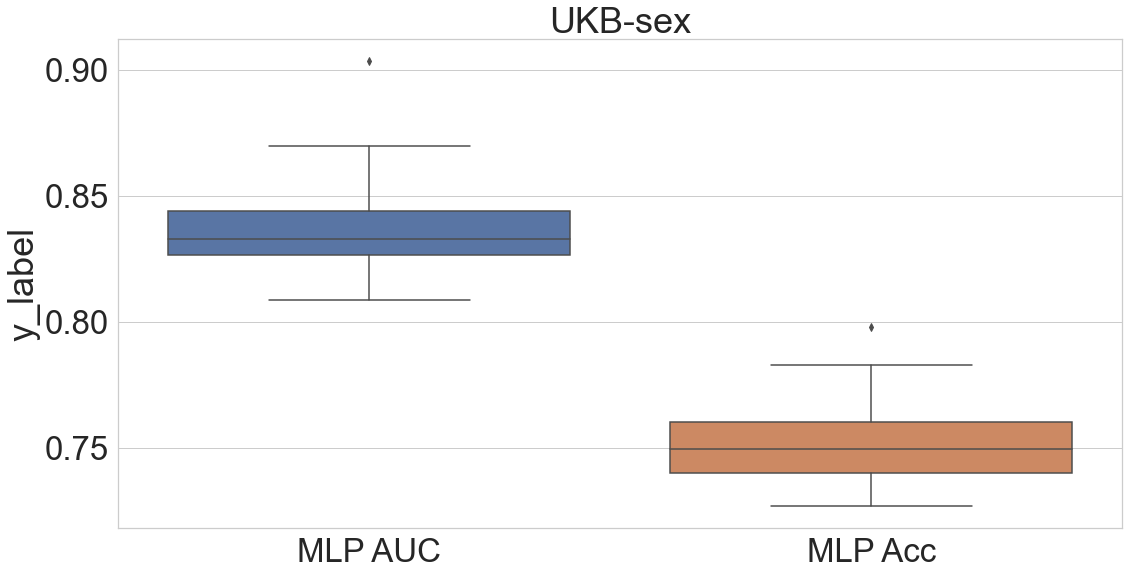

In [37]:
data = [mlp_ukb_AUC, mlp_ukb_accuracy]
data_names = ["MLP AUC", "MLP Acc"]
plot_box_plots(data, data_names, "UKB-sex", "y_label")


# Testing different MLP models on FBIRN

## MLP architectures

In [3]:
# MLP

mlp_fbirn_AUC, mlp_fbirn_accuracy = load_metrics_from_wandb("experiment-mlp-fbirn")

# No Residual block MLP

nores_mlp_fbirn_AUC, nores_mlp_fbirn_accuracy = load_metrics_from_wandb("experiment-nores_mlp-fbirn")

# Transposed MLP

trans_mlp_fbirn_AUC, trans_mlp_fbirn_accuracy = load_metrics_from_wandb("experiment-trans_mlp-fbirn")

# no ensemble MLP

noens_mlp_fbirn_AUC, noens_mlp_fbirn_accuracy = load_metrics_from_wandb("experiment-noens_mlp-fbirn")

In [4]:
data = [
    pd.DataFrame(
        {
            "AUC": mlp_fbirn_AUC,
            "Accuracy": mlp_fbirn_accuracy,
            "Model": ["MLP"]*50,
            "Dataset": ["FBIRN"]*50,
        }
    ), 
    pd.DataFrame(
        {
            "AUC": nores_mlp_fbirn_AUC,
            "Accuracy": nores_mlp_fbirn_accuracy,
            "Model": ["NoRes MLP"]*50,
            "Dataset": ["FBIRN"]*50,
        }
    ), 
    pd.DataFrame(
        {
            "AUC": trans_mlp_fbirn_AUC,
            "Accuracy": trans_mlp_fbirn_accuracy,
            "Model": ["Trans MLP"]*50,
            "Dataset": ["FBIRN"]*50,
        }
    ), 
    pd.DataFrame(
        {
            "AUC": noens_mlp_fbirn_AUC,
            "Accuracy": noens_mlp_fbirn_accuracy,
            "Model": ["NoEns MLP"]*50,
            "Dataset": ["FBIRN"]*50,
        }
    ), 
]
data = pd.concat(data)
data.to_csv("./MLP_arch_tests.csv")

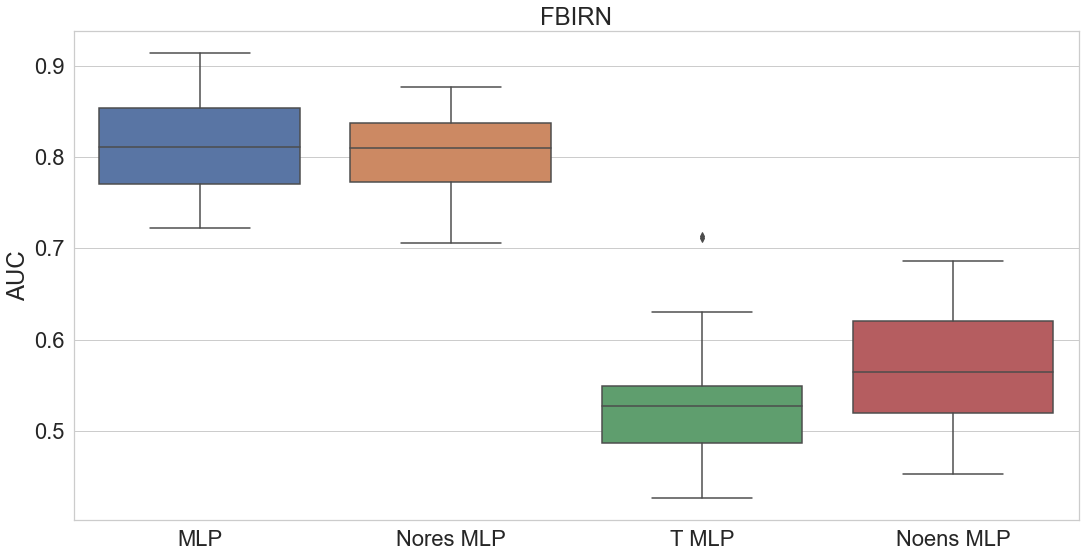

In [5]:
auc_data = [mlp_fbirn_AUC, nores_mlp_fbirn_AUC, trans_mlp_fbirn_AUC, noens_mlp_fbirn_AUC]
data_names = ["MLP", "Nores MLP", "T MLP", "Noens MLP"]
plot_box_plots(auc_data, data_names, "FBIRN", "AUC")

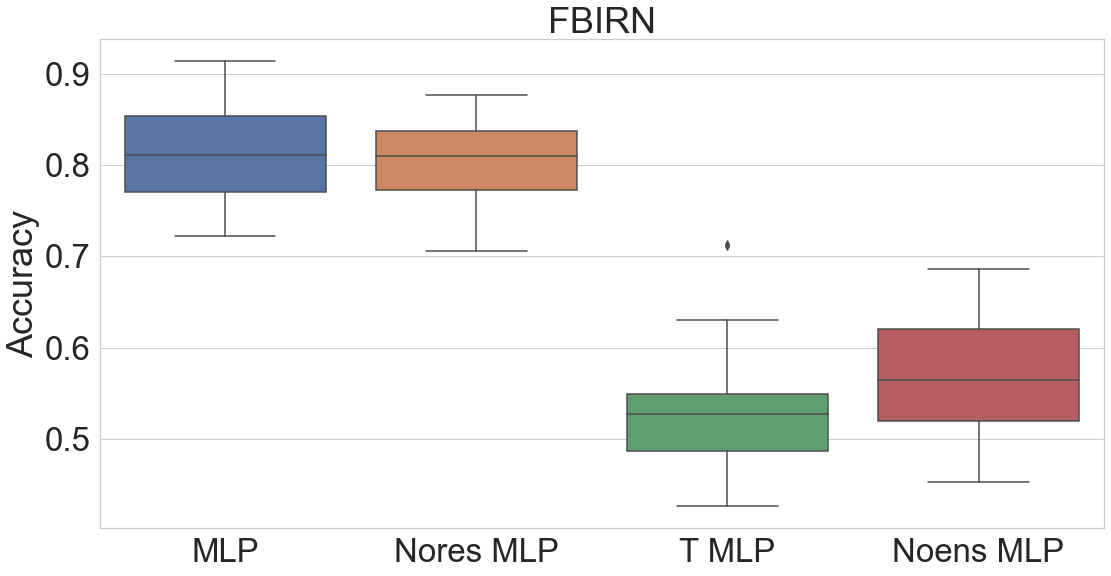

In [43]:
acc_data = [mlp_fbirn_accuracy, nores_mlp_fbirn_accuracy, trans_mlp_fbirn_accuracy, noens_mlp_fbirn_accuracy]
data_names = ["MLP", "Nores MLP", "T MLP", "Noens MLP"]
plot_box_plots(auc_data, data_names, "FBIRN", "Accuracy")

## Deep, wide and attention MLP

In [28]:
# Simple MLP

mlp_fbirn_AUC, mlp_fbirn_accuracy = load_metrics_from_wandb("220817.031422-experiment-mlp-fbirn")

# Deep MLP

deep_mlp_fbirn_AUC, deep_mlp_fbirn_accuracy = load_metrics_from_wandb("220817.020923-experiment-deep_mlp-fbirn")

# Wide MLP

wide_mlp_fbirn_AUC, wide_mlp_fbirn_accuracy = load_metrics_from_wandb("220817.000759-tune-wide_mlp-fbirn")

# old attention MLP

old_attn_mlp_fbirn_AUC, old_attn_mlp_fbirn_accuracy = load_metrics_from_wandb("220817.044951-experiment-attention_mlp-fbirn")

# new attention MLP

new_attn_mlp_fbirn_AUC, new_attn_mlp_fbirn_accuracy = load_metrics_from_wandb("220817.041043-experiment-new_attention_mlp-fbirn")

# newest attention MLP

newest_attn_mlp_fbirn_AUC, newest_attn_mlp_fbirn_accuracy = load_metrics_from_wandb("220820.010149-experiment-newest_attention_mlp-fbirn")

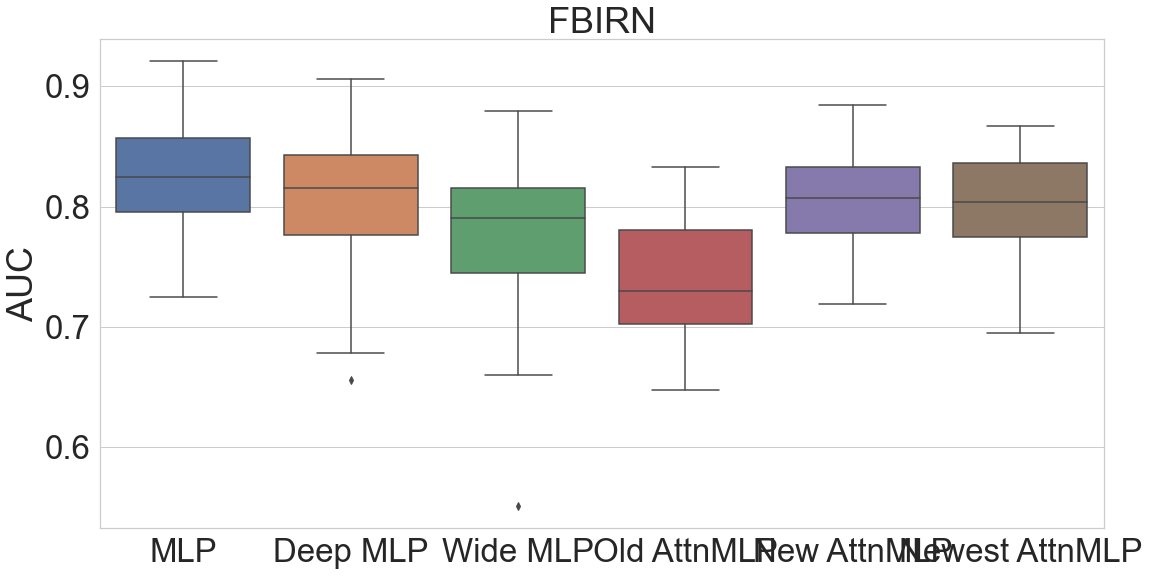

In [32]:
auc_data = [mlp_fbirn_AUC, deep_mlp_fbirn_AUC, wide_mlp_fbirn_AUC, old_attn_mlp_fbirn_AUC, new_attn_mlp_fbirn_AUC, newest_attn_mlp_fbirn_AUC]
data_names = ["MLP", "Deep MLP", "Wide MLP", "Old AttnMLP", "New AttnMLP", "Newest AttnMLP"]
plot_box_plots(auc_data, data_names, "FBIRN", "AUC")

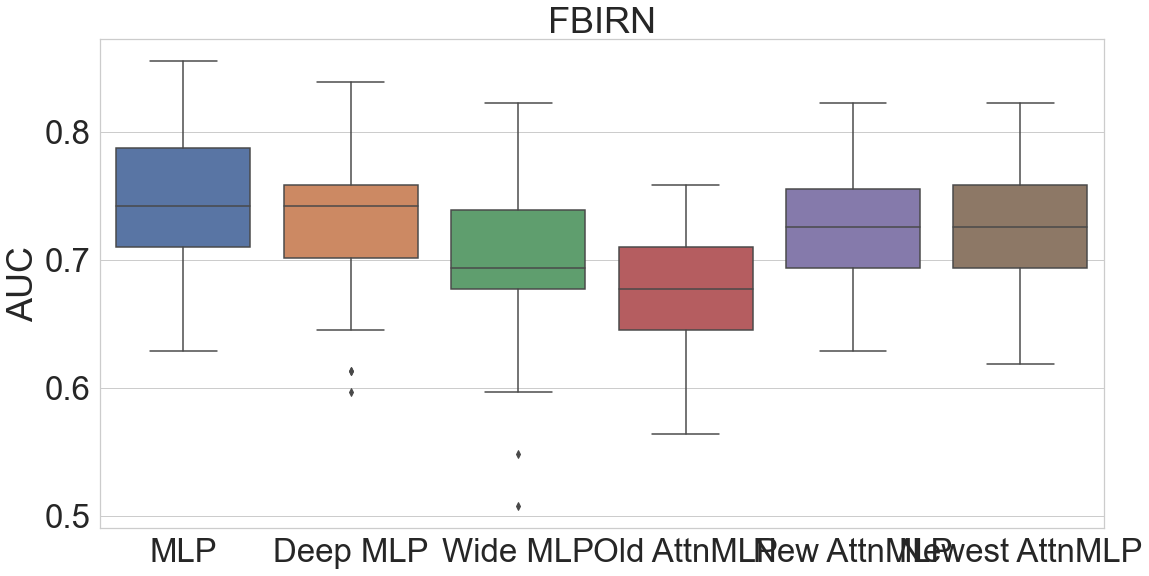

In [33]:
acc_data = [mlp_fbirn_accuracy, deep_mlp_fbirn_accuracy, wide_mlp_fbirn_accuracy, old_attn_mlp_fbirn_accuracy, new_attn_mlp_fbirn_accuracy, newest_attn_mlp_fbirn_accuracy]
data_names = ["MLP", "Deep MLP", "Wide MLP", "Old AttnMLP", "New AttnMLP", "Newest AttnMLP"]
plot_box_plots(acc_data, data_names, "FBIRN", "AUC")

# Experiments

#### All together

In [17]:
proj_names = [
    #OASIS
    "220811.052827-experiment-mlp-oasis",
    "220817.022010-experiment-new_attention_mlp-oasis",
    "new-experiment-milc-oasis",
    "NPT-experiment-milc-oasis",
    "220817.085028-experiment-lstm-oasis",
    "220823.054741-experiment-another_lstm-oasis",
    "220825.183225-experiment-transformer-oasis",
    #ABIDE
    "220811.190848-experiment-mlp-abide",
    "220817.033648-experiment-new_attention_mlp-abide",
    "new-experiment-milc-abide",
    "220817.131942-experiment-lstm-abide",
    "220823.122916-experiment-another_lstm-abide",
    "220826.154213-experiment-transformer-abide",
    #Abide 869
    "220811.221744-experiment-mlp-abide_869",
    "220817.052433-experiment-new_attention_mlp-abide_869",
    "new-experiment-milc-abide_869",
    "220820.205431-experiment-lstm-abide_869",
    "220824.025849-experiment-another_lstm-abide_869",
    "220826.214154-experiment-transformer-abide_869",
    #FBIRN
    "220817.031422-experiment-mlp-fbirn",
    "220817.041043-experiment-new_attention_mlp-fbirn",
    "newer-experiment-milc-fbirn",
    "220817.225007-experiment-lstm-fbirn",
    "220823.220212-experiment-another_lstm-fbirn",
    "220826.185919-experiment-transformer-fbirn",
    "noah-experiment-noah_lstm-fbirn-tests-cobre_bsnip",
    "deep_noah-experiment-deep_noah_lstm-fbirn-tests-cobre_bsnip",
    "mean_transformer-experiment-mean_transformer-fbirn-tests-cobre_bsnip",
    #COBRE
    "220827.014957-experiment-mlp-cobre-tests-fbirn_bsnip",
    "220830.025754-experiment-new_attention_mlp-cobre",
    "newer-experiment-milc-cobre",
    "220830.080927-experiment-lstm-cobre",
    "220831.070739-experiment-another_lstm-cobre",
    "220831.224232-experiment-transformer-cobre",
    #BSNIP
    "220827.012730-experiment-mlp-bsnip-tests-fbirn_cobre",
    "220830.041453-experiment-new_attention_mlp-bsnip",
    "newer-experiment-milc-bsnip",
    "220831.003802-experiment-lstm-bsnip",
    "220831.123732-experiment-another_lstm-bsnip",
    "220901.064229-experiment-transformer-bsnip",
    #HCP
    "221021.065816-experiment-mlp-hcp",
    #UKB
    "123-experiment-mlp-ukb",
    # Time and time-inversed FBIRN
    "220930.164853-experiment-mlp-time_fbirn"
]

all_data = [pd_load_metrics_from_wandb(x) for x in proj_names]
all_data = pd.concat(all_data)

In [18]:
all_data.to_csv("./plots_data/all_ICA_data.csv")

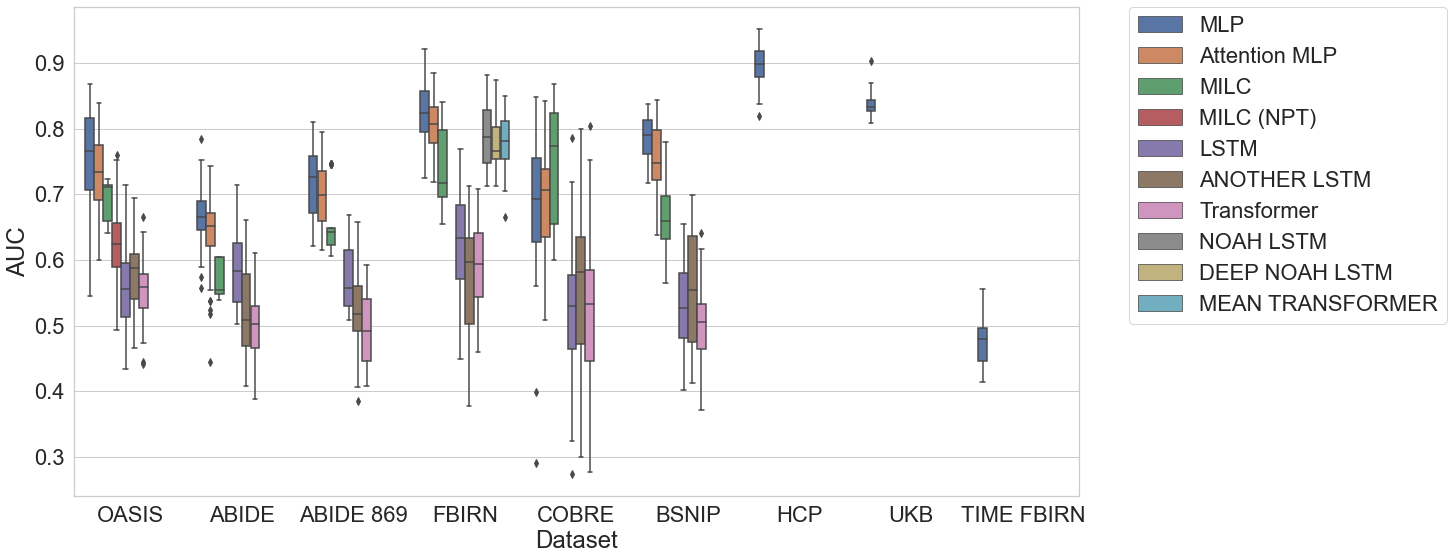

In [19]:
sns.boxplot(x="Dataset", y="AUC",
            hue="Model",
            data=all_data)
# sns.despine(offset=10, trim=True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

plt.savefig(
    "./images/all_auc.png",
    format="png",
    dpi=300,
    bbox_inches='tight',
)
plt.savefig(
    "./images/all_auc.svg",
    bbox_inches='tight',
)

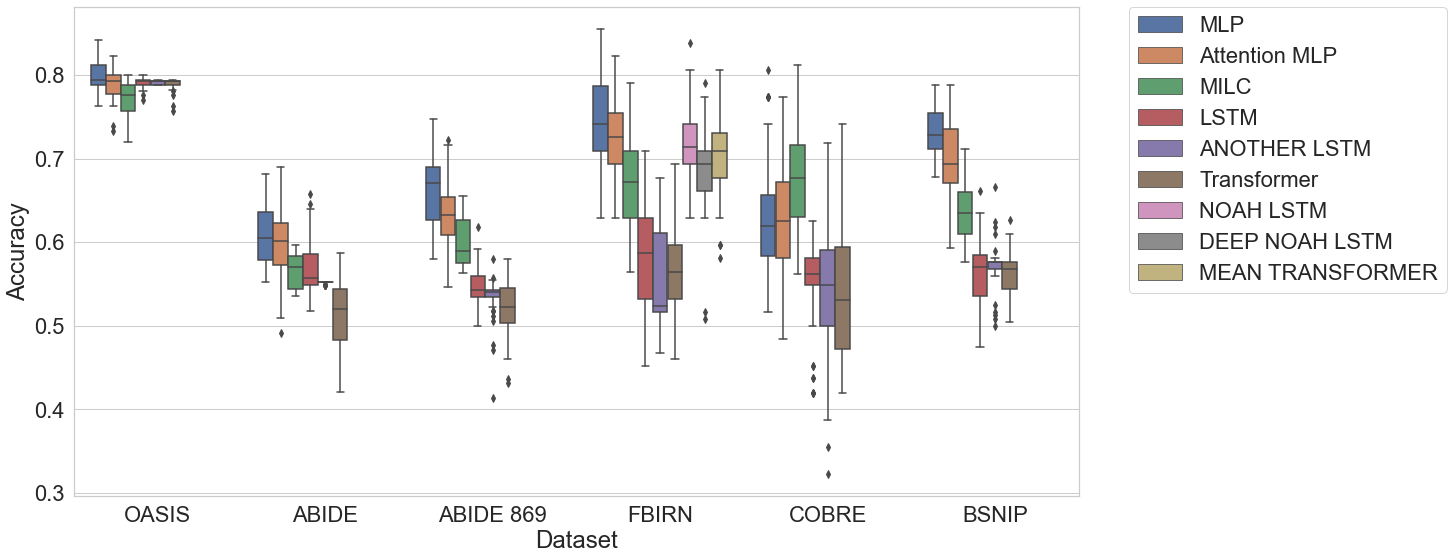

In [39]:
sns.boxplot(x="Dataset", y="Accuracy",
            hue="Model",
            data=all_data)
# sns.despine(offset=10, trim=True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

plt.savefig(
    "./images/all_acc.png",
    format="png",
    dpi=300,
    bbox_inches='tight',
)
plt.savefig(
    "./images/all_acc.svg",
    bbox_inches='tight',
)

# FBIRN only

In [19]:
proj_names = [
    #FBIRN
    "220817.031422-experiment-mlp-fbirn",
    "220817.041043-experiment-new_attention_mlp-fbirn",
    "newer-experiment-milc-fbirn",
    "220817.225007-experiment-lstm-fbirn",
    "220823.220212-experiment-another_lstm-fbirn",
    "220826.185919-experiment-transformer-fbirn",
    "noah-experiment-noah_lstm-fbirn-tests-cobre_bsnip",
    "deep_noah-experiment-deep_noah_lstm-fbirn-tests-cobre_bsnip",
    "mean_transformer-experiment-mean_transformer-fbirn-tests-cobre_bsnip",
    "last_noah-experiment-last_noah_lstm-fbirn-tests-cobre_bsnip"
]

all_data = [pd_load_metrics_from_wandb(x) for x in proj_names]
all_data = pd.concat(all_data)

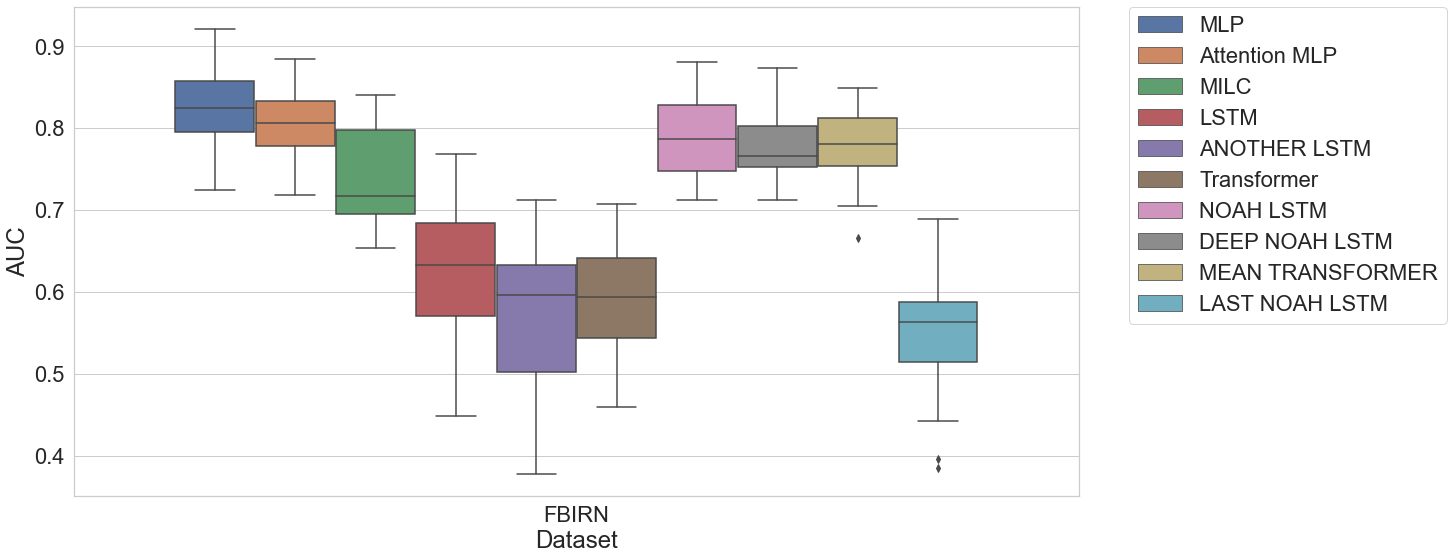

In [20]:
sns.boxplot(x="Dataset", y="AUC",
            hue="Model",
            data=all_data)
# sns.despine(offset=10, trim=True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

plt.show()

#### MLP-MILC Cross-dataset together

In [59]:
proj_names = [
    # MLP
    ("220827.011216-experiment-mlp-fbirn-tests-cobre_bsnip_abide", ""),
    ("220827.011216-experiment-mlp-fbirn-tests-cobre_bsnip_abide", "bsnip"),
    ("220827.011216-experiment-mlp-fbirn-tests-cobre_bsnip_abide", "cobre"),
    #
    ("220827.012730-experiment-mlp-bsnip-tests-fbirn_cobre", ""),
    ("220827.012730-experiment-mlp-bsnip-tests-fbirn_cobre", "fbirn"),
    ("220827.012730-experiment-mlp-bsnip-tests-fbirn_cobre", "cobre"),
    #
    ("220827.014957-experiment-mlp-cobre-tests-fbirn_bsnip", ""),
    ("220827.014957-experiment-mlp-cobre-tests-fbirn_bsnip", "fbirn"),
    ("220827.014957-experiment-mlp-cobre-tests-fbirn_bsnip", "bsnip"),
    # Fixed MILC
    ("newer-experiment-milc-fbirn", ""),
    ("newer-experiment-milc-fbirn", "bsnip"),
    ("newer-experiment-milc-fbirn", "cobre"),
    #
    ("newer-experiment-milc-bsnip", ""),
    ("newer-experiment-milc-bsnip", "fbirn"),
    ("newer-experiment-milc-bsnip", "cobre"),
    #
    ("newer-experiment-milc-cobre", ""),
    ("newer-experiment-milc-cobre", "fbirn"),
    ("newer-experiment-milc-cobre", "bsnip"),
]
cross_data = [pd_load_metrics_from_wandb(x[0], x[1]) for x in proj_names]

proj_names = [
    # NPT MILC
    ("NPT-experiment-milc-fbirn", "", "NPT MILC"),
    ("NPT-experiment-milc-fbirn", "bsnip", "NPT MILC"),
    ("NPT-experiment-milc-fbirn", "cobre", "NPT MILC"),
    #
    ("NPT-experiment-milc-bsnip", "", "NPT MILC"),
    ("NPT-experiment-milc-bsnip", "fbirn", "NPT MILC"),
    ("NPT-experiment-milc-bsnip", "cobre", "NPT MILC"),
    #
    ("NPT-experiment-milc-cobre", "", "NPT MILC"),
    ("NPT-experiment-milc-cobre", "fbirn", "NPT MILC"),
    ("NPT-experiment-milc-cobre", "bsnip", "NPT MILC"),
]
cross_data.extend([pd_load_metrics_from_wandb(x[0], x[1], model_name=x[2]) for x in proj_names])
cross_data = pd.concat(cross_data)

In [60]:
cross_data.to_csv("./cross_dataset_experiments.csv")

In [ ]:
cross_data = pd.read_csv("./cross_dataset_experiments.csv")

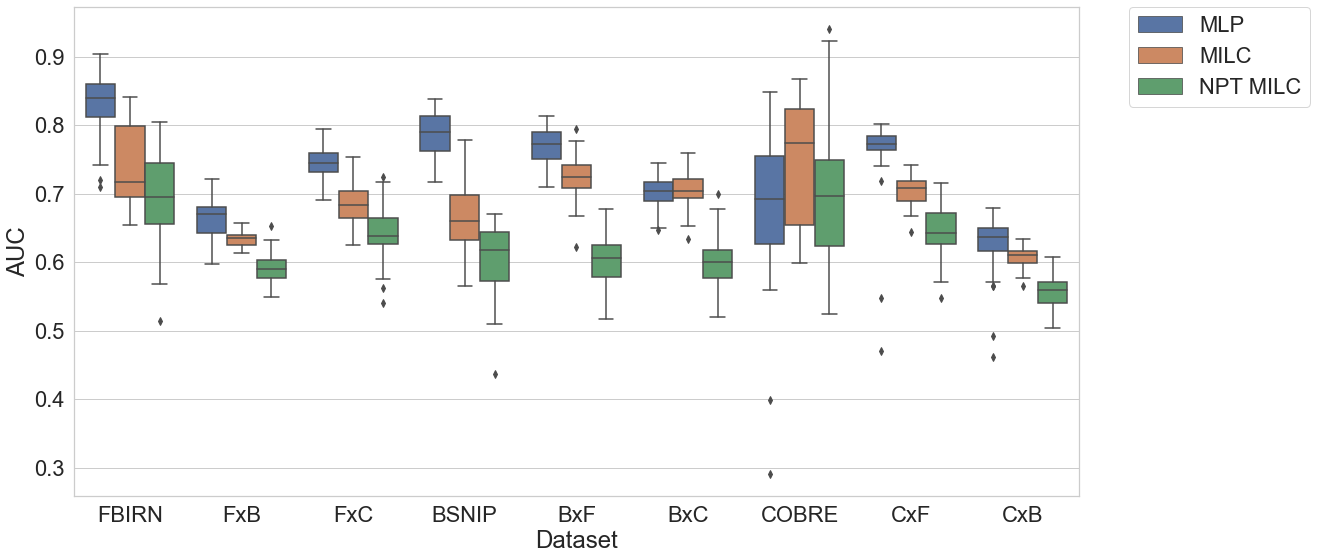

In [63]:
sns.boxplot(x="Dataset", y="AUC",
            hue="Model",
            data=cross_data)
# sns.despine(offset=10, trim=True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

plt.savefig(
    "./images/cross_auc.png",
    format="png",
    dpi=300,
    bbox_inches='tight',
)

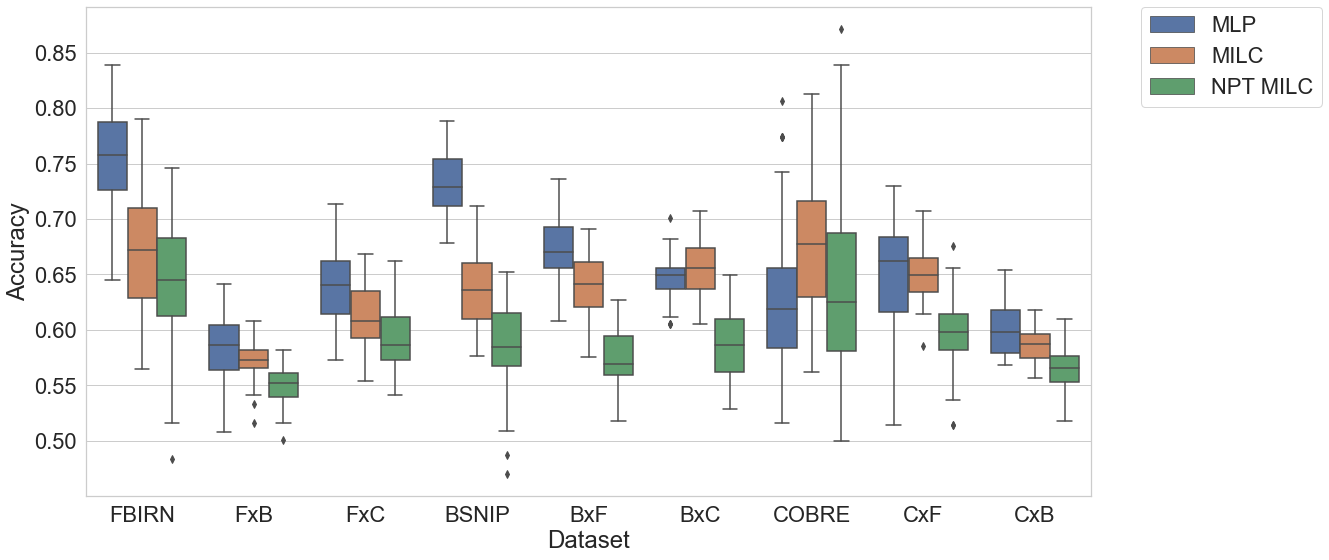

In [64]:
sns.boxplot(x="Dataset", y="Accuracy",
            hue="Model",
            data=cross_data)
# sns.despine(offset=10, trim=True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

plt.savefig(
    "./images/cross_acc.png",
    format="png",
    dpi=300,
    bbox_inches='tight',
)

#### MLP time - inversed time FBIRN

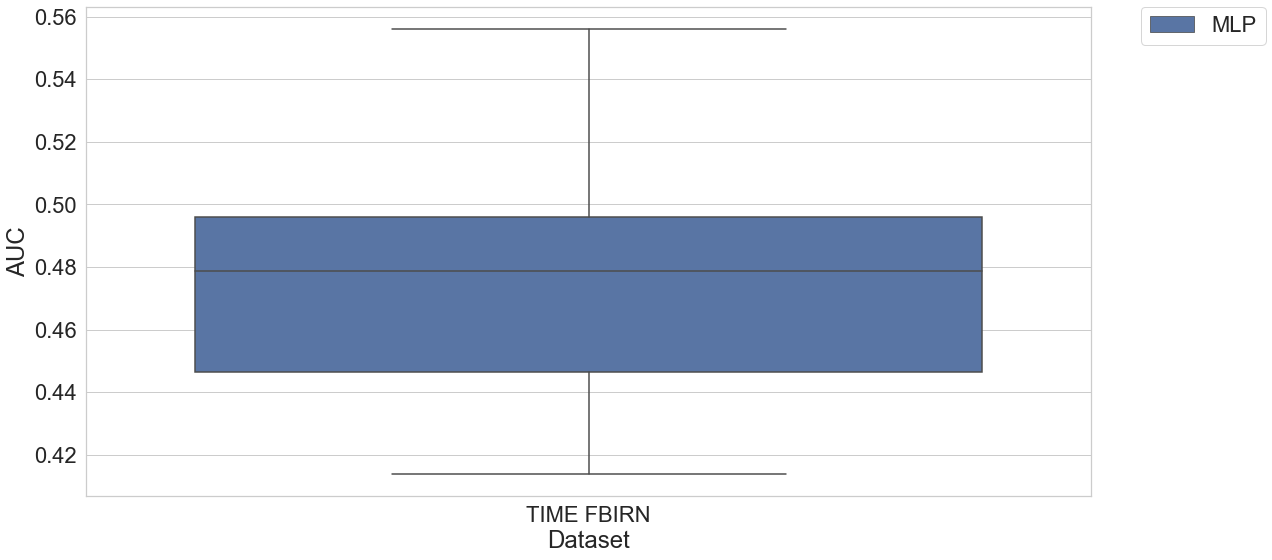

In [6]:

data = pd_load_metrics_from_wandb("220930.164853-experiment-mlp-time_fbirn")
sns.boxplot(x="Dataset", y="AUC",
            hue="Model",
            data=data)
# sns.despine(offset=10, trim=True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

plt.show()

#### Scaled FBIRN experiments

In [9]:
path = [
    ("220827.011216-experiment-mlp-fbirn-tests-cobre_bsnip_abide", "FBIRN"),
    ("220817.225007-experiment-lstm-fbirn", "FBIRN"),
    ("noah-experiment-noah_lstm-fbirn-tests-cobre_bsnip", "FBIRN")

]
scale_data = [pd_load_metrics_from_wandb(x[0], dataset_name=x[1]) for x in path]

path = [
    ("final-experiment-mlp-scaled_fbirn-tests-cobre_bsnip", "Time Scaled FBIRN"),
    ("final-experiment-lstm-scaled_fbirn-tests-cobre_bsnip", "Time Scaled FBIRN"),
]
scale_data.extend([pd_load_metrics_from_wandb(x[0], dataset_name=x[1]) for x in path])

path = [
    ("channel-experiment-mlp-scaled_fbirn-tests-cobre_bsnip", "Channel Scaled FBIRN"),
    ("channel-experiment-lstm-scaled_fbirn-tests-cobre_bsnip", "Channel Scaled FBIRN"),
]
scale_data.extend([pd_load_metrics_from_wandb(x[0], dataset_name=x[1]) for x in path])

path = [
    ("tm-experiment-mlp-scaled_fbirn-tests-cobre_bsnip", "Time-channel Scaled FBIRN"),
    ("tm-experiment-lstm-scaled_fbirn-tests-cobre_bsnip", "Time-channel Scaled FBIRN"),
]
scale_data.extend([pd_load_metrics_from_wandb(x[0], dataset_name=x[1]) for x in path])

scale_data = pd.concat(scale_data)

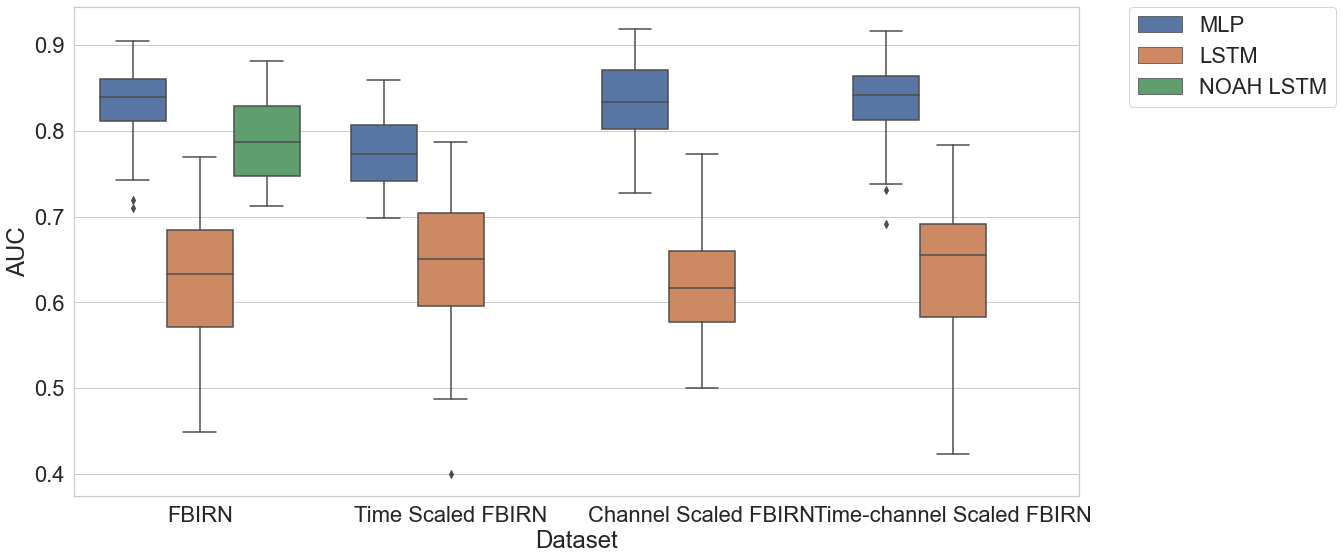

In [10]:
sns.boxplot(x="Dataset", y="AUC",
            hue="Model",
            data=scale_data)
# sns.despine(offset=10, trim=True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

plt.show()

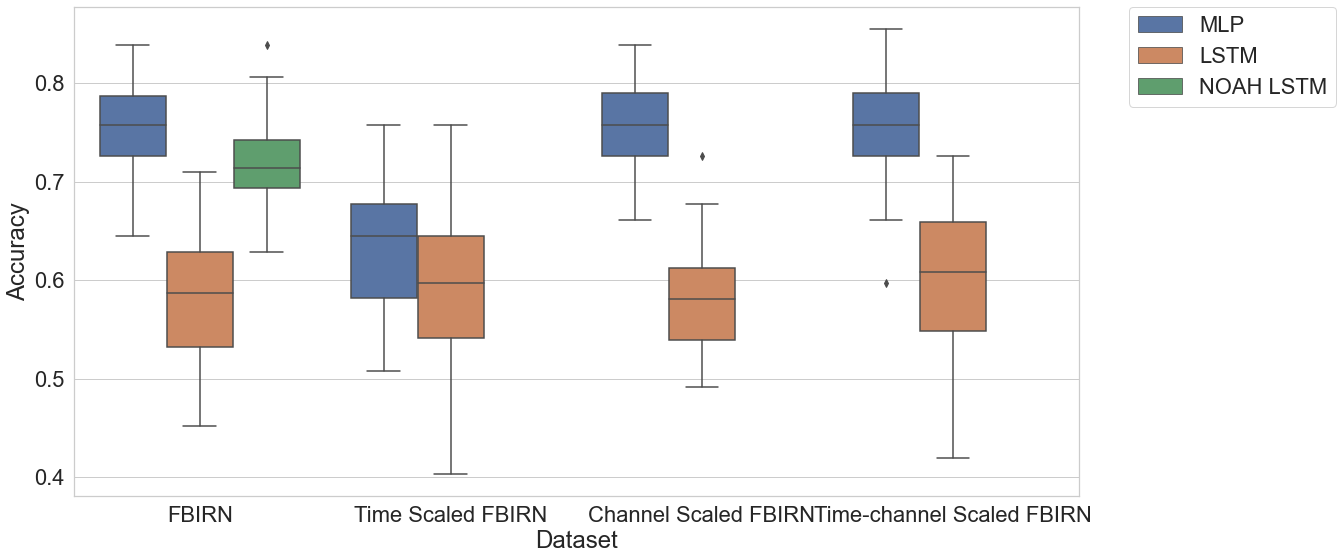

In [11]:
sns.boxplot(x="Dataset", y="Accuracy",
            hue="Model",
            data=scale_data)
# sns.despine(offset=10, trim=True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

plt.show()

#### ICA-ROI experiments

In [81]:
# FBIRN
path = [
    # MLP
    ("220827.011216-experiment-mlp-fbirn-tests-cobre_bsnip_abide", "FBIRN ICA"),
    ("221018.212243-experiment-mlp-fbirn_100", "FBIRN Schaefer 100"),
    ("221018.220806-experiment-mlp-fbirn_200", "FBIRN Schaefer 200"),
    ("221018.230636-experiment-mlp-fbirn_400", "FBIRN Schaefer 400"),
    ("221019.012758-experiment-mlp-fbirn_1000", "FBIRN Schaefer 1000"),
    # Wide MLP
    ("221024.223822-experiment-wide_mlp-fbirn", "FBIRN ICA"),
    ("221020.073358-experiment-wide_mlp-fbirn_100", "FBIRN Schaefer 100"),
    ("221020.095601-experiment-wide_mlp-fbirn_200", "FBIRN Schaefer 200"),
    ("221020.142405-experiment-wide_mlp-fbirn_400", "FBIRN Schaefer 400"),
    ("221020.233150-experiment-wide_mlp-fbirn_1000", "FBIRN Schaefer 1000"),
    # LSTM
    ("220817.225007-experiment-lstm-fbirn", "FBIRN ICA"),
    ("221021.183513-experiment-lstm-fbirn_100", "FBIRN Schaefer 100"),
    ("221022.012316-experiment-lstm-fbirn_200", "FBIRN Schaefer 200"),
    ("221022.062133-experiment-lstm-fbirn_400", "FBIRN Schaefer 400"),
    ("221023.065038-experiment-lstm-fbirn_1000", "FBIRN Schaefer 1000"),
    # Transformer
    ("220826.185919-experiment-transformer-fbirn", "FBIRN ICA"),
    ("221023.063324-experiment-transformer-fbirn_100", "FBIRN Schaefer 100"),
    ("221023.101246-experiment-transformer-fbirn_200", "FBIRN Schaefer 200"),
    ("221023.144808-experiment-transformer-fbirn_400", "FBIRN Schaefer 400"),
    ("221023.234336-experiment-transformer-fbirn_1000", "FBIRN Schaefer 1000"),
    # Other
    ("221019.112734-experiment-mlp-hcp_roi", "HCP Schaefer 200"),
    ("221021.065816-experiment-mlp-hcp", "HCP ICA"),
    ("221019.144727-experiment-mlp-abide_roi", "Abide 871 Schaefer 200"),
    ("220811.190848-experiment-mlp-abide", "Abide 569 ICA"),
    ("220811.221744-experiment-mlp-abide_869", "Abide 869 ICA"),
]
data = [pd_load_metrics_from_wandb(x[0], dataset_name=x[1]) for x in path]

data = pd.concat(data)

In [79]:
data.to_csv("./plots_data/ICA_ROI_data.csv")

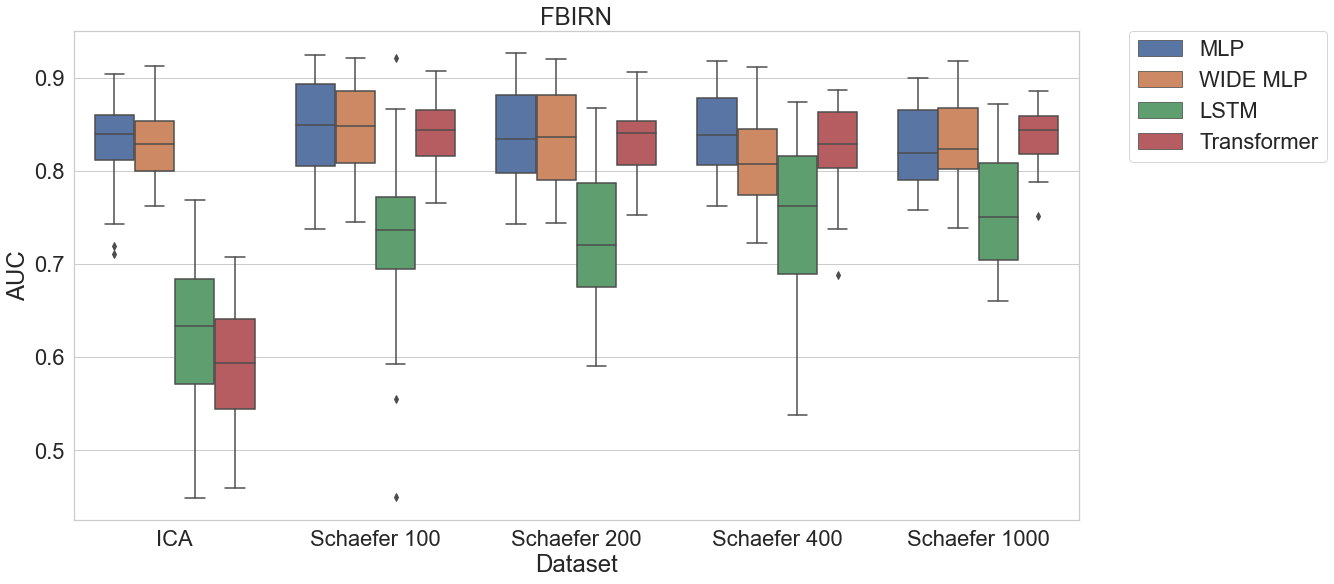

In [82]:
sns.boxplot(x="Dataset", y="AUC",
            data=data,
            hue="Model"
            )
# sns.despine(offset=10, trim=True)
plt.title("FBIRN")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

plt.savefig(
    "./roi_experiments/fbirn.png", 
    format="png",
    dpi=300,
    bbox_inches='tight'
)
plt.savefig("./roi_experiments/fbirn.svg", bbox_inches='tight')

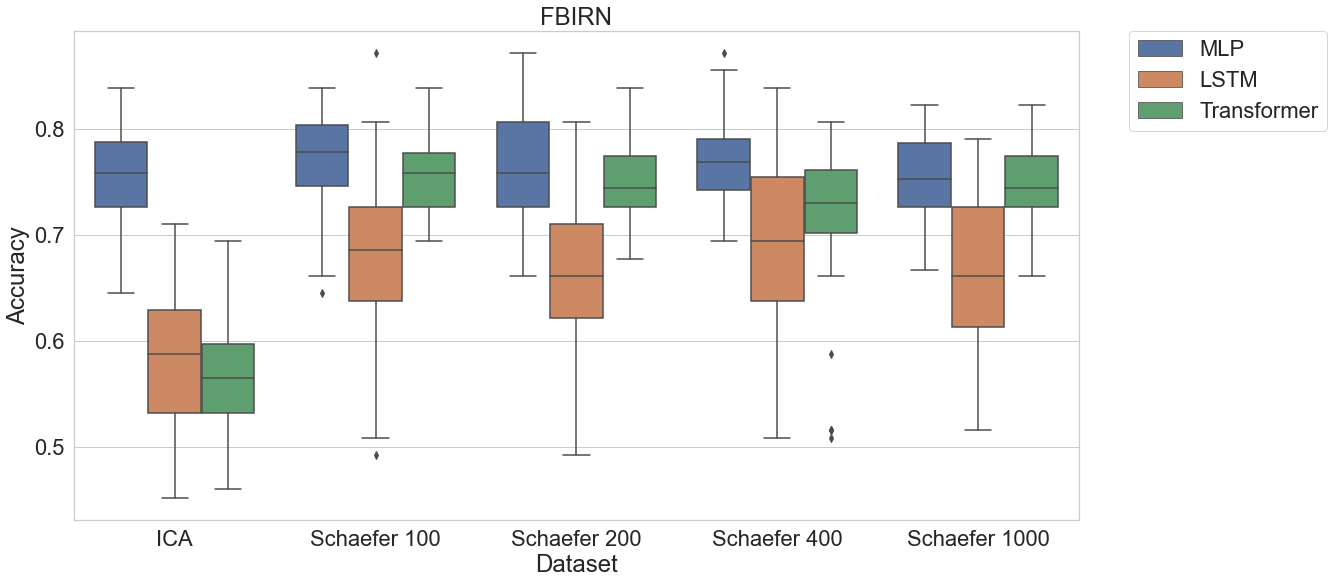

In [49]:
sns.boxplot(x="Dataset", y="Accuracy",
            data=data,
            hue="Model"
            )
# sns.despine(offset=10, trim=True)
plt.title("FBIRN")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

plt.savefig(
    "./roi_experiments/fbirn_acc.png", 
    format="png",
    dpi=300,
    bbox_inches='tight'
)
plt.savefig("./roi_experiments/fbirn_acc.svg", bbox_inches='tight')

In [51]:
# HCP and Abide
path = [
    ("221019.112734-experiment-mlp-hcp_roi", "HCP Schaefer 200"),
    ("221021.065816-experiment-mlp-hcp", "HCP ICA"),
    ("221019.144727-experiment-mlp-abide_roi", "Abide 871 Schaefer 200"),
    ("220811.190848-experiment-mlp-abide", "Abide 569 ICA"),
    ("220811.221744-experiment-mlp-abide_869", "Abide 869 ICA"),
]

data = [pd_load_metrics_from_wandb(x[0], dataset_name=x[1]) for x in path]

data = pd.concat(data)

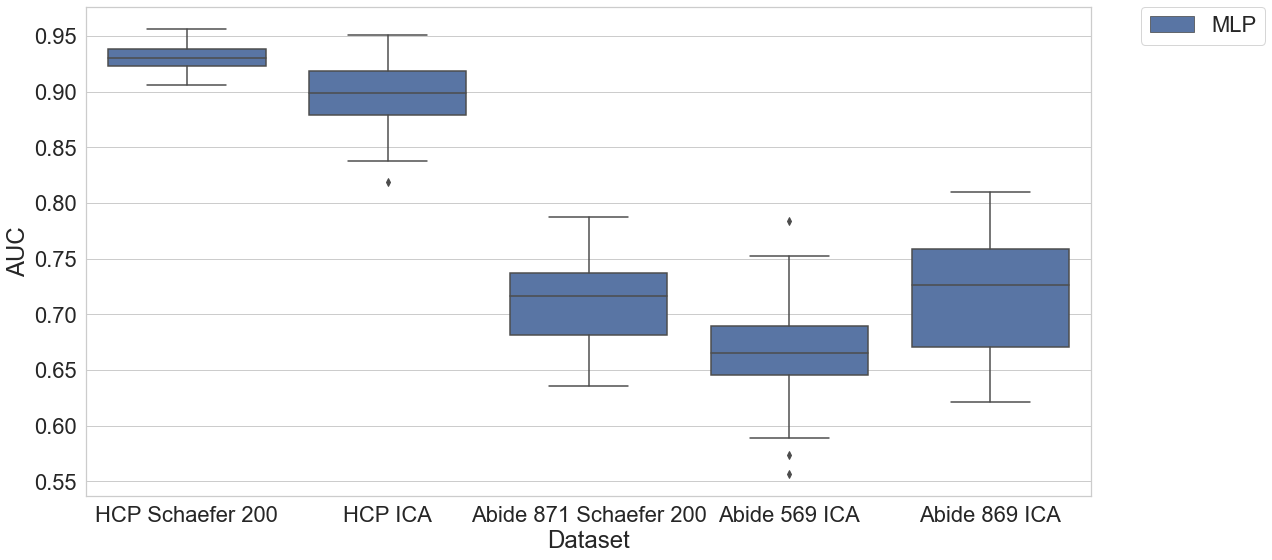

In [53]:
sns.boxplot(x="Dataset", y="AUC",
            data=data,
            hue="Model"
            )
# sns.despine(offset=10, trim=True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

plt.savefig(
    "./roi_experiments/hcp_abide.png",
    format="png",
    dpi=300,
    bbox_inches='tight'
)
plt.savefig("./roi_experiments/hcp_abide.svg")

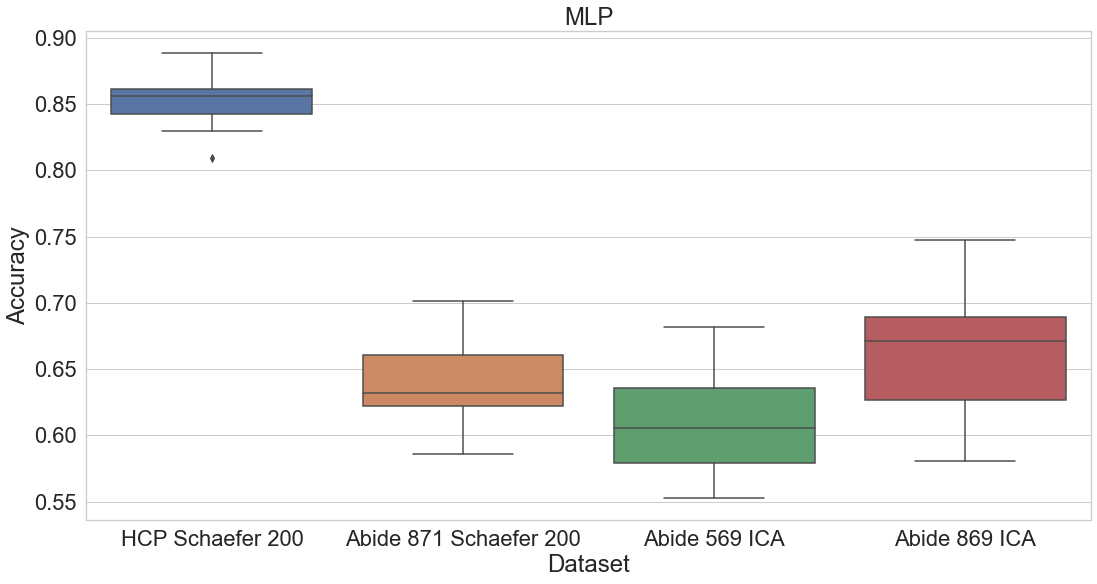

In [31]:
sns.boxplot(x="Dataset", y="Accuracy",
            data=data,
            )
# sns.despine(offset=10, trim=True)
plt.title("MLP")

plt.savefig(
    "./roi_experiments/hcp_abide_acc.png",
    format="png",
    dpi=300,
    bbox_inches='tight'
)
plt.savefig("./roi_experiments/hcp_abide_acc.svg")

# New MLP designs

In [4]:
mlp_AUC, _ = load_metrics_from_wandb("220817.031422-experiment-mlp-fbirn")
meta_mlp_AUC, _ = load_metrics_from_wandb("test-experiment-meta_mlp-fbirn")
window_mlp_lstm_AUC, _ = load_metrics_from_wandb("test-experiment-window_mlp_lstm_NPT-fbirn")
window_mlp_tf_AUC, _ = load_metrics_from_wandb("test-experiment-window_mlp_tf_NPT-fbirn")

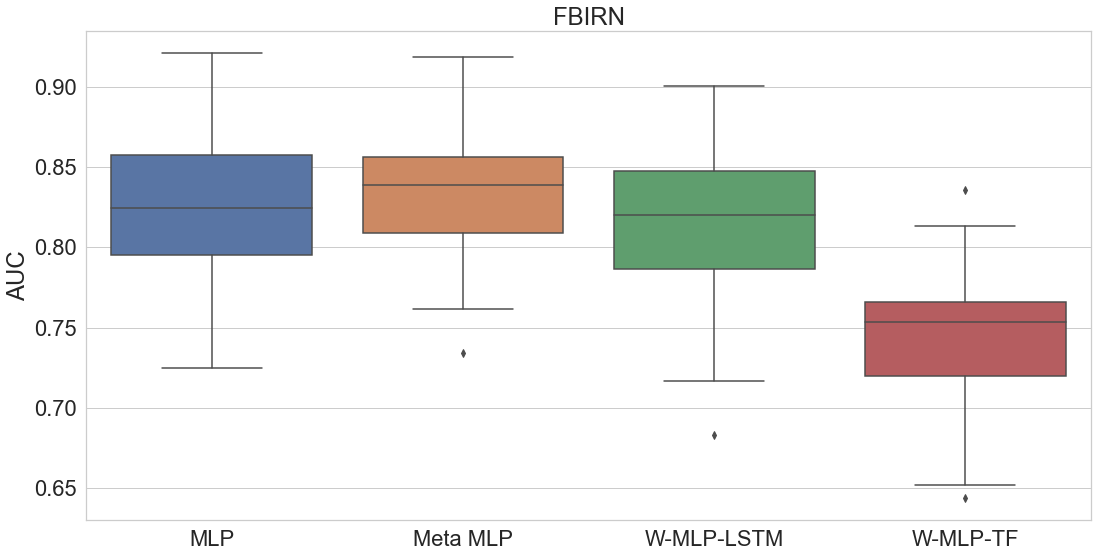

In [5]:
data = [mlp_AUC, meta_mlp_AUC, window_mlp_lstm_AUC, window_mlp_tf_AUC]
data_names = ["MLP", "Meta MLP", "W-MLP-LSTM", "W-MLP-TF"]
plot_box_plots(data, data_names, "FBIRN", "AUC")

In [ ]:
mlp_AUC, _ = load_metrics_from_wandb("220827.011216-experiment-mlp-fbirn-tests-cobre_bsnip_abide")
lstm_AUC, _ = load_metrics_from_wandb("220817.225007-experiment-lstm-fbirn")
tf_AUC, _ = load_metrics_from_wandb("220826.185919-experiment-transformer-fbirn")
new_tf_AUC, _ = load_metrics_from_wandb("test-experiment-first_transformer-fbirn")

- why transformer is bad? try other designs

- position encoding - модуляция по времени

- ADNI-MCI-OASIS - alzheimer

- articles in neuroimaging - what do they look like

- target idea - out goal is to make people carefull about using model performance metrics as the goal, a measure of quality for new models

- написать макет по русски, вставить опорные картинки

- что может быть целью, кроме interpretability? У Винса есть идея, что по временному слою можно 
Гипнограммы - данные 

- обыграть ультрафиолетовую катастрофу
